In [ ]:
import torch
import torchvision


from IPython.display import clear_output
import time
import tqdm
from tqdm import tqdm_notebook
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
torch.cuda.is_available()

True

In [ ]:
train_val_dataset = torchvision.datasets.CIFAR10(root='./data',train=True,transform=torchvision.transforms.ToTensor(),download=True)
test_dataset = torchvision.datasets.CIFAR10(root='./data',train=False, transform=torchvision.transforms.ToTensor(),download=True)
train_dataset, val_dataset = torch.utils.data.random_split(train_val_dataset, [40000,10000])
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
BATCH_SIZE = 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
def plot_learning_curves(history):
    '''
     
    This function is aimed to show up at all loss and accuracy (metrics) during the training of the model

    :param history: (dict)
        accuracy and loss on the training and validation
    '''
    # sns.set_style(style='whitegrid')

    fig = plt.figure(figsize=(20, 7))

    plt.subplot(1,2,1)
    plt.title('Loss', fontsize=15)

    plt.plot(history['loss']['train'], label='train')
    plt.plot(history['loss']['val'], label='validation')

    plt.ylabel('Loss', fontsize=15)
    plt.xlabel('Num epochs', fontsize=15)
    plt.legend()

    plt.subplot(1,2,2)
    plt.title('Accuracy', fontsize=15)
    plt.plot(history['acc']['train'], label='train')
    plt.plot(history['acc']['val'], label='validation')
    plt.ylabel('Accuracy', fontsize=15)
    plt.xlabel('Num epochs', fontsize=15)
    plt.legend()
    plt.show()

In [ ]:
class SimpleConvNet(torch.nn.Module):
  def __init__(self):
    super().__init__()
    
    self.conv1 = torch.nn.Conv2d(in_channels = 3,out_channels = 128, kernel_size = 7,stride = 1) 
    self.relu1 = torch.nn.LeakyReLU()
    self.mp1 = torch.nn.MaxPool2d(kernel_size = 2,stride = 2,padding = 0,dilation=1,ceil_mode=False)
    self.bn1 = torch.nn.BatchNorm2d(128)
    self.droupout1 = torch.nn.Dropout(0.3)
    # [batch,128, 13 , 13]
        
    self.conv2 = torch.nn.Conv2d(in_channels=128, out_channels=256, kernel_size=5,stride=1)
    self.bn2 = torch.nn.BatchNorm2d(256)
    self.droupout2 = torch.nn.Dropout(0.3)
    self.relu2 = torch.nn.LeakyReLU()
    #[batch,256,9,9]

    self.conv3 = torch.nn.Conv2d(in_channels=256,out_channels=256,kernel_size=5,stride=1)
    self.bn3 = torch.nn.BatchNorm2d(256)
    self.dropout3 = torch.nn.Dropout(0.3)
    self.relu3 = torch.nn.LeakyReLU()
    #[batch,256,5,5]
        
    self.flatten = torch.nn.Flatten()
    self.fc4 = torch.nn.Linear(256*5*5, 512)
    self.droupout4 = torch.nn.Dropout(0.3)
    self.relu4 = torch.nn.ReLU()
    self.fc5 = torch.nn.Linear(512, 10)

  def forward(self, x):
    layer1 = self.mp1(self.relu1(self.conv1(x)))
    layer1 = self.droupout1(self.bn1(layer1))
        
    layer2 = self.conv2(layer1)
    layer2 = self.relu2(self.droupout2(self.bn2(layer2)))

    layer3 = self.conv3(layer2)
    layer3 = self.relu3(self.dropout3(self.bn3(layer3)))
        
    out = self.flatten(layer3)
    out = self.relu4(self.droupout4(self.fc4(out)))
    out = self.fc5(out)
    return out # [batch,10] i.e. batch of logits

In [ ]:
def train(
    model,     # SimpleConvNet()
    criterion, # torch.nn.CrossEntropyLoss()
    optimizer, # torch.optim.SGD()
    train_loader, 
    val_loader,
    num_epochs=50 
):
    '''
    Функция для обучения модели и вывода лосса и метрики во время обучения.

    :param model: trained model
    :param criterion: Loss function
    :param optimizer: method of optimization
    :param train_loader: data loader for training
    :param val_loader: data loader for validation
    :param num_epochs: num epochs

    :return: learned model
    :return: (dict) accuracy and loss on training and validation ("история" обучения)
    '''

    history = defaultdict(lambda: defaultdict(list))

    for epoch in tqdm_notebook(range(num_epochs)):

        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0
        
        start_time = time.time()

        #  set behaviour dropout / batch_norm  in training
        model.train(True) 

        for X_batch, y_batch in train_loader:
            X_batch = X_batch.cuda()
            y_batch = y_batch.cuda()
            
            logits = model(X_batch)
            
            loss = criterion(logits, y_batch.long().cuda())

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            train_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            train_acc += np.mean(y_batch.cpu().numpy() == y_pred)

        # calcukate loss and accuracy and  save to "историю"
        train_loss /= len(train_loader)
        train_acc /= len(train_loader) 
        history['loss']['train'].append(train_loss)
        history['acc']['train'].append(train_acc)
    
        # set behaviour dropout / batch_norm  in testing session
        model.train(False) 
   
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.cuda()
            y_batch = y_batch.cuda()
            
            logits = model(X_batch)
            loss = criterion(logits, y_batch.long().cuda())
            val_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            val_acc += np.mean(y_batch.cpu().numpy() == y_pred)

        val_loss /= len(val_loader)
        val_acc /= len(val_loader) 
        history['loss']['val'].append(val_loss)
        history['acc']['val'].append(val_acc)
        
        clear_output()
        
        #print results after each epoch
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(train_loss))
        print("  validation loss (in-iteration): \t{:.6f}".format(val_loss))
        print("  training accuracy: \t\t\t{:.2f} %".format(train_acc * 100))
        print("  validation accuracy: \t\t\t{:.2f} %".format(val_acc * 100))
        
        plot_learning_curves(history)
        
    return model, history

In [ ]:
def run_many_models(count_of_models,num_epochs):

  conv1_tensor = torch.empty_like(torch.randn((128,3,7,7)))
  conv2_tensor = torch.empty_like(torch.randn((256,128,5,5)))
  conv3_tensor = torch.empty_like(torch.randn((256,256,5,5)))

  for num_model in tqdm_notebook(range(count_of_models)):

    model = SimpleConvNet().cuda()
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

    model, history = train(
      model, criterion, optimizer, 
      train_loader, val_loader, 
      num_epochs
    )

    conv1_tensor = torch.cat([conv1_tensor,model.conv1.weight.detach().cpu()])
    conv2_tensor = torch.cat([conv2_tensor,model.conv2.weight.detach().cpu()])
    conv3_tensor = torch.cat([conv3_tensor,model.conv3.weight.detach().cpu()])
  
  conv1_tensor = conv1_tensor.reshape([count_of_models + 1,128,3,7,7])[1:]
  conv2_tensor = conv2_tensor.reshape([count_of_models + 1,256,128,5,5])[1:]
  conv3_tensor = conv3_tensor.reshape([count_of_models + 1,256,256,5,5])[1:]

  return conv1_tensor,conv2_tensor,conv3_tensor
    

Epoch 50 of 50 took 17.571s
  training loss (in-iteration): 	0.124817
  validation loss (in-iteration): 	0.832288
  training accuracy: 			95.65 %
  validation accuracy: 			79.20 %


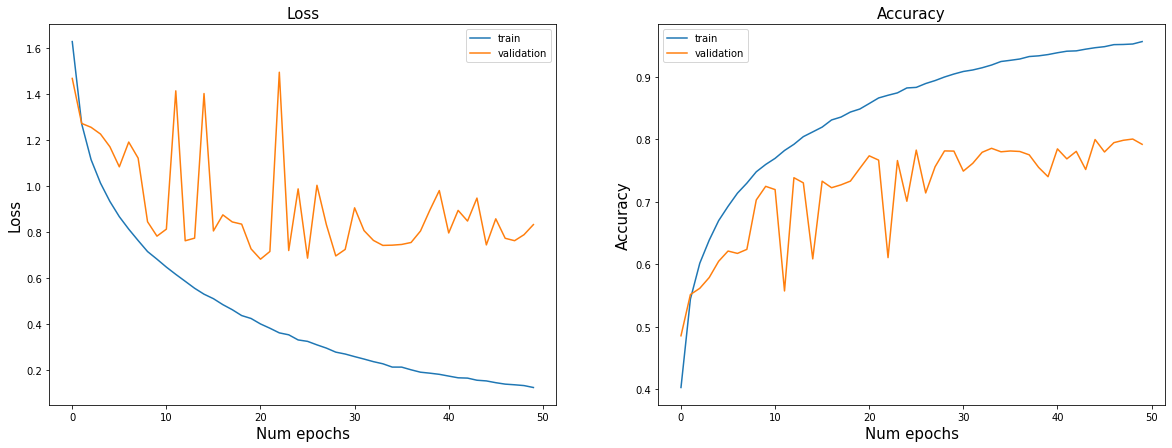

In [33]:
conv1_tensor,conv2_tensor,conv3_tensor = run_many_models(5,50)

Now, one can download this filters to google drive:


1.   1st file: torch.Size([num_models,128,3,7,7])
2.   2nd file: torch.Size([num_models,256,128,5,5])
3.   3rd file: torch.Size([num_models,256,256,5,5])



In [68]:
# download
import pickle
import os
path = os.path.join('drive', 'My Drive','filters', 'Filters_1_layer_3.pkl') # path
with open(path, 'wb') as handle:
    pickle.dump(tensor_1_3, handle)

In [87]:
# upload
path = os.path.join('drive', 'My Drive','filters', 'Filters_2_layer_3.pkl')
with open(path, 'rb') as handle:
    tensor_ = pickle.load(handle)

In [73]:
#conv1_tensor_ = torch.cat([tensor_,tensor])
#conv2_tensor_ = torch.cat([tensor_,tensor])
conv3_tensor_= torch.cat([tensor_,tensor])

In [90]:
filters_1 = conv1_tensor_.reshape(8*128*3,7,7)
filters_2 = conv2_tensor_.reshape(8*256*128,5,5)
filters_3 = conv3_tensor_.reshape(8*256*256,5,5)

norms_1 = torch.linalg.norm(filters_1,dim=(-2,-1))
norms_2 = torch.linalg.norm(filters_2,dim=(-2,-1))
norms_3 = torch.linalg.norm(filters_3,dim=(-2,-1))
norms = list()
norms.extend([norms_1,norms_2,norms_3])

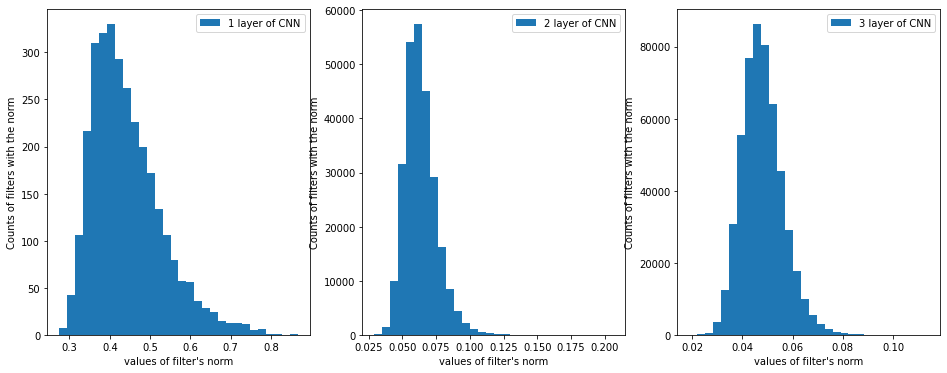

In [91]:
fig,ax = plt.subplots(nrows=1,ncols=3,figsize=(16,6))
ax = ax.flatten()
for idx in range(3):
  ax[idx].hist(norms[idx], density=False, bins=30,label= str(idx + 1) + " layer of CNN") 
  ax[idx].set_ylabel('Counts of filters with the norm')
  ax[idx].set_xlabel("values of filter's norm")
  ax[idx].legend()
plt.show();